
# Librerie

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import poppy
import astropy.units as u
import logging
logging.basicConfig(level=logging.DEBUG)
from astropy.io import fits
from astropy.modeling import models, fitting
import tifffile
import numpy as np
import matplotlib.colors as mcolors
from astropy.stats import sigma_clip
logging.getLogger().setLevel(logging.INFO)
from scipy.optimize import curve_fit
import photutils
import time
import datetime as dt
from scipy import fftpack
import nbformat
import plotly.graph_objects as go
from PIL import Image
from turbustat.statistics import PowerSpectrum
from scipy.signal import butter, filtfilt
import ipywidgets as widgets
from IPython.display import display, clear_output
from astropy.io.fits import Header
from scipy.signal import find_peaks
import os
import csv
import gc
import re
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from photutils.aperture import ApertureStats
from astropy.table import Table
import warnings
from astropy.utils.exceptions import AstropyUserWarning
import winsound
import pandas as pd
from astropy.table import Table

# Colormap
dark_yellow = [ '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']
custom_cmap = mcolors.LinearSegmentedColormap.from_list("DarkYellow", dark_yellow)
gradient = np.linspace(0, 1, 256).reshape(1, -1)



<span style="color:yellow; font-size:40px;">Variabili in input</span> 


In [2]:
############### PER SPECKLE FIT ###################################
speckle_thresholds=[3000, 4000, 10000]  # l'ultimo era 12000 primada cambiare a seconda dei target usati prima era 3000 non 2000
speckle_threshold=7000 #1100 #7000 #9500 #8000 #9000 #6500 #9000
# Plate scale arcseconds/pixels
plate_scales=[0.0377,  0.0109, 0.012]  #plate cslae di gennaio, febbraio e marzo rispettivamente
plate_scale = 0.0109 # 0.012#4-MARZO #0.0109 #FEBBRAIO# 0.0377 #0.0244*2 #0.0376*2 #0.0268 marzo #0.0244 febb #0.0376 #
# Diffraction limit of the telescope
aperture = 1.82                                                     # Aperture of the telescope (in meters)
wavelength = 633e-9 #700e-9                                                 # Reference wavelenght (in meters) 
diffraction_limit_radians = 2*1.22 * wavelength / aperture          # Diameter of the Airy disk
diffraction_limit_arcseconds = diffraction_limit_radians * 206265
expected_speckle_size_radians = 0.8038 *(1.22 * wavelength / aperture)
expected_speckle_size = expected_speckle_size_radians * 206265  
expected_speckle_size_pixels = expected_speckle_size / plate_scale
# Radius use for the fit of the speckles (in pixels)
radius=int((diffraction_limit_arcseconds/plate_scale)/2)  # raggio della zona del fit attorno alle speckle (Diametro = disco di airy)
check_radius = int((diffraction_limit_arcseconds*0.5)/plate_scale) # raggio della zona di controllo attorno alle speckle (Diametro = disco di airy)
mindist = 5 #distanza dimina in pixel tra 2 speckle (per evitare che la stessa speckle venga contata più volte)
#print("Diffraction limit in arcseconds and pixels: ",diffraction_limit_arcseconds, diffraction_limit_arcseconds/plate_scale)
print("Expected speckle size in arcseconds and pixels: ", expected_speckle_size, expected_speckle_size_pixels)

###########    PER PSD   ##################################################
ordine = 5 #  NON OLTRE 6
imagenumber = 300 #500
stacked = False  # Fa PSD di più immagini sommate (3 al momento)
nstack = 3 # immagini da sommare se si vuole usare il Power specrum di immagini sommate
lowcut_pix = 14#15#7  #max dimension in pixel
highcut_pix = 4#9#2.1  #min dimension in pixel
lowcut= 1/lowcut_pix 
highcut = 1/highcut_pix
crop_size = 2000   # FORMATO IMMAGINE FINALE: N pixel X N pixel (dimiuisce la dimensione dell'immagine per velocizzare i calcoli)
frequency_range = 0.15    # range per trovare il picco delle spckle (centrato nella frequenza delle speckle teorica)
########################################################

Expected speckle size in arcseconds and pixels:  0.07035025819440659 6.45415212792721


# <span style="color:orange; font-size: 1em;"> Funzioni

In [3]:
def calcProcessTime(starttime, cur_iter, max_iter):

    telapsed = time.time() - starttime
    testimated = (telapsed/cur_iter)*(max_iter)
    finishtime = starttime + testimated
    finishtime = dt.datetime.fromtimestamp(finishtime).strftime("%H:%M:%S")
    lefttime = testimated-telapsed 

    return (int(telapsed), int(lefttime), finishtime)
######################################################################################################################
######################################################################################################################

def fit_speckle_tot(data, filtered_speckles, radius, speckle_threshold, plate_scale):
    fwhm_results = []
    centers = []
    
    for speckle in filtered_speckles:
        y_ref, x_ref = speckle  
        masked_data = data.copy() 
        y, x = np.mgrid[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
        masked_data = masked_data[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
        masked_data[masked_data < 0] = 0 
        
        ###########################################################################
        #Se attivo, fa il fit in una regione circolare
        distance = np.sqrt((x - x_ref)**2 + (y - y_ref)**2)
        circular_mask = distance <= radius
        masked_data = np.where(circular_mask, masked_data, 0)
        ##############################################################################
        
        # Set border pixels to 0
        masked_data[0, :] = 0
        masked_data[-1, :] = 0
        masked_data[:, 0] = 0
        masked_data[:, -1] = 0

        gaussian_model = models.Gaussian2D(amplitude=masked_data.max(), x_mean=x_ref, y_mean=y_ref, x_stddev=0.5, y_stddev=0.5)
        gaussian_model.amplitude.min = speckle_threshold
        gaussian_model.amplitude.max = masked_data.max()
        gaussian_model.x_mean.min = x_ref - 5   # METTERE A 1 PER LE SPECKLE A 3X
        gaussian_model.x_mean.max = x_ref + 5
        gaussian_model.y_mean.min = y_ref - 5
        gaussian_model.y_mean.max = y_ref + 5

        fitter = fitting.LevMarLSQFitter()
        fitted_model = fitter(gaussian_model, x, y, masked_data)

        fwhm_x = 2.355 * fitted_model.x_stddev.value * plate_scale
        fwhm_y = 2.355 * fitted_model.y_stddev.value * plate_scale
        fwhm_results.append((fwhm_y, fwhm_x))
        centers.append((fitted_model.y_mean.value, fitted_model.x_mean.value))

    return np.array(fwhm_results), np.array(centers)
######################################################################################################################
######################################################################################################################

def gaussiana(bins, media, sigma):
	x = np.zeros(len(bins)-1)
	for i in range(len(x)):
		x[i] = (bins[i]+bins[i+1])/2
	y = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-media)**2/(2*sigma**2))
	return x, y
######################################################################################################################
######################################################################################################################

def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)

######################################################################################################################
######################################################################################################################

def butterworth_2d_bandpass(image, lowcut, highcut, order=5):
    ny, nx = image.shape
    y, x = np.ogrid[:ny, :nx]
    cy, cx = ny // 2, nx // 2
    # Create normalized radius grid (distance from center)
    radius = np.sqrt((x - cx)**2 + (y - cy)**2)
    radius /= np.max(radius)  # Normalize to [0, 1]
    # Normalize lowcut/highcut to [0, 1] as fraction of Nyquist
    low = lowcut * 2
    high = highcut * 2
    # Butterworth bandpass formula
    def butterworth(freq, cutoff, n):
        return 1 / (1 + (freq / cutoff)**(2 * n))
    # Bandpass = Highpass * Lowpass
    lowpass = butterworth(radius, high, order)
    highpass = 1 - butterworth(radius, low, order)
    bandpass_mask = lowpass * highpass
    # Apply filter in frequency domain
    fft_image = np.fft.fft2(image)
    fft_shifted = np.fft.fftshift(fft_image)
    filtered_fft = fft_shifted * bandpass_mask
    filtered_image = np.fft.ifft2(np.fft.ifftshift(filtered_fft)).real
    return filtered_image, bandpass_mask
######################################################################################################################
######################################################################################################################

def crop_center(image, size):
    """
    Crop a square region of given size around the image center.

    """
    ny, nx = image.shape
    cx, cy = nx // 2, ny // 2
    half = size // 2
    x_min = cx - half
    x_max = cx + half
    y_min = cy - half
    y_max = cy + half
    return image[y_min:y_max, x_min:x_max]

######################################################################################################################
######################################################################################################################

def plot_psd_peak(freqs, ps1D, largest_peak_freq, frequency_range, expected_speckle_size, plate_scale):
    zoom_range = (largest_peak_freq - frequency_range / 2, largest_peak_freq + frequency_range / 2)
    zoom_indices = (freqs >= zoom_range[0]) & (freqs <= zoom_range[1])
    zoom_freqs = freqs[zoom_indices]
    zoom_power = ps1D[zoom_indices]
    plt.figure(figsize=(8, 6))
    plt.loglog(zoom_freqs, zoom_power, label='Zoomed Power Spectrum')  # Emphasize the zoomed region
    plt.axvline(x=largest_peak_freq, color='red', linestyle='--', label=f'Peak: {largest_peak_freq:.4f} pix⁻¹')
    plt.axvline(x=1/(expected_speckle_size/plate_scale), color='magenta', linestyle='--', label='Expected Speckle Size')
    plt.title("Zoomed View of Power Spectrum near Largest Peak")
    plt.xlabel("Spatial Frequency [pix⁻¹]")
    plt.ylabel("Power")
    plt.title("Zoomed View of Power Spectrum near Largest Peak")
    plt.grid(True, which="both", linestyle='--')
    plt.legend()
    plt.show()
    
##################################################################################
######################################################################################
def find_peak_power(freqs, ps1D, expected_speckle_size_pixels, frequency_range):
    """
    frequency_range : Range around the expected speckle frequency to search for the peak.
    largest_peak_freq : Frequency with the largest power within the specified range.
    largest_peak_power : Largest power within the specified frequency range.
    """
    expected_speckle_frequency = 1 / expected_speckle_size_pixels
    lower_freq = expected_speckle_frequency - frequency_range / 2
    upper_freq = expected_speckle_frequency + frequency_range / 2
    #print(expected_speckle_size_pixels,expected_speckle_frequency, lower_freq, upper_freq)
    peak_indices = (freqs >= lower_freq) & (freqs <= upper_freq)

    if not any(peak_indices):
        print("No frequencies selected within the specified range.")
        return None, None

    selected_freqs = freqs[peak_indices]
    selected_power = ps1D[peak_indices]
    largest_peak_index = np.argmax(selected_power)
    largest_peak_freq = selected_freqs[largest_peak_index]
    largest_peak_power = selected_power[largest_peak_index]
    
    return largest_peak_freq, largest_peak_power
#################################################################################
##################################################################################
def scale_and_speckle_selector(plate_scales, speckle_thresholds, file):
    if 'arcturus' in file:
        speckle_threshold = speckle_thresholds[1]
    if 'castor' in file:
        speckle_threshold = speckle_thresholds[0]
    if 'aldebaran' in file:
        speckle_threshold = speckle_thresholds[2]   
    if 'febbraio' in file:
        plate_scale = plate_scales[1]
    if 'marzo' in file:
        plate_scale = plate_scales[2]
    print("Plate scale in arcseconds/pixel: ", plate_scale)
    print("Speckle threshold: ", speckle_threshold)
    return plate_scale, speckle_threshold
#######################################################################################################################
#######################################################################################################################
def code_end_alert():
    duration = 5000  # milliseconds
    freqs = [440, 550, 660, 770, 880, 990]  # A few different frequencies
    for freq in freqs:
        winsound.Beep(freq, duration // len(freqs))  # Divide duration to keep total time similar
    freqs = freqs[:-1]
    for freq in reversed(freqs):
        winsound.Beep(freq, duration // (len(freqs)+1))
    print("Code execution completed")
########################################################################################################
#######################################################################################################
song_jojo = "B4 B4 B4 A4 B4 D5 B4 A4 B4 B4 B4 A4 B4 F4 E4 D4"
song_allstar = "C R G E E R D C C F R E E D D C"
def musichetta(song):
    base_freq = 440  # A4
    ratio = 2 ** (1/12)  # precise semitone ratio
    base_note_index = {'C': -9, 'C#': -8, 'D': -7, 'D#': -6, 'E': -5,
                       'F': -4, 'F#': -3, 'G': -2, 'G#': -1, 'A': 0,
                       'A#': 1, 'B': 2}

    def get_freq(note_with_octave):
        if note_with_octave == 'R':
            return None
        note = ''.join(filter(str.isalpha, note_with_octave))
        accidental = '#' if '#' in note_with_octave else ''
        octave = int(''.join(filter(str.isdigit, note_with_octave)) or 4)
        semitone_offset = base_note_index.get(note + accidental, 0)
        n = semitone_offset + (octave - 4) * 12
        return int(base_freq * (ratio ** n))

    def play_note(note, duration=250):
        freq = get_freq(note)
        if freq:
            winsound.Beep(freq, duration)
        else:
            time.sleep(duration / 1000)

    for note in song.split():
        play_note(note)
############################################################################################
##########################################################################################

# <span style="color:red; font-size: 1em;"> Codice

In [51]:
warnings.filterwarnings('ignore', category=UserWarning, module='astropy')


folder_path = r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\marzo\4-03"
file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.tif')]
#immagini_list = []

all_dfs = []  # lista per accumulare i DataFrame di ogni file

print(f"Found {len(file_list)} files in the folder")
for file in file_list: 
    #file = r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\marzo\4-03\castor_marzo_40ms_elev75.tif"
    file_name = os.path.basename(file)
    immagini = tifffile.imread(file)[:2000]  #immagini_list.append(immagini)
    print(f"Loaded data from {file_name}")
    print(f'Analysing {file_name}...')
    
    plate_scale, speckle_threshold = scale_and_speckle_selector(plate_scales, speckle_thresholds, file_name)
    diffraction_limit_radians = 2*1.22 * wavelength / aperture          # Diameter of the Airy disk
    diffraction_limit_arcseconds = diffraction_limit_radians * 206265
    expected_speckle_size_radians = 0.8038 *(1.22 * wavelength / aperture)
    expected_speckle_size = expected_speckle_size_radians * 206265  
    expected_speckle_size_pixels = expected_speckle_size / plate_scale
    # Radius use for the fit of the speckles (in pixels)
    radius=int((diffraction_limit_arcseconds/plate_scale)/2)  # raggio della zona del fit attorno alle speckle (Diametro = disco di airy)
    check_radius = int((diffraction_limit_arcseconds*0.5)/plate_scale) # raggio della zona di controllo attorno alle speckle (Diametro = disco di airy)
    #mindist = 5 #distanza dimina in pixel tra 2 speckle (per evitare che la stessa speckle venga contata più volte)
    
    ############# SPECKLE FIT ##########################################################
    
    start = time.time()
    fwhm_single_image = []
    fwhm_mean_all = []
    fwhm_median_all = []
    fwhm_std_all = []
    centroid_all = []   # first coordinate in the array is the Y
    rms_all = []        # first coordinate in the array is the Y
    fwhm_mean_filtered_all = []
    fwhm_median_filtered_all = []
    fwhm_std_filtered_all = []
    rms_filtered_all = []
    centroid_filtered_all = []
    ellipticity_mean_all=[]

    for imagenumber in range(len(immagini)):
        data_raw = immagini[imagenumber]
        data_clean = data_raw
        poisson_error = np.sqrt(data_raw)
        background_level = np.median(data_raw)
        background_error = np.sqrt(background_level)
        noise = np.sqrt(np.mean(poisson_error**2) + background_error**2)
        background_estimate = data_raw - noise
        background_estimate[background_estimate < 0] = 0
        data = data_raw - background_level
        data[data < 0] = 0

        ###########################     SOLO PER 10KHZ ################################################
        #center_y, center_x = data.shape[0] // 2, data.shape[1] // 2
        #search_radius = 80  ###per speckle a 3x
        #y, x = np.ogrid[:data.shape[0], :data.shape[1]]
        #mask = (x - center_x)**2 + (y - center_y)**2 <= search_radius**2
        #speckle_coords = np.column_stack(np.where((data > speckle_threshold) & mask))
        ################################################################################################
        # QUANDO NON ATTIVO SPECKLE A 10KHZ
        speckle_coords = np.column_stack(np.where(data > speckle_threshold))
        real_speckles = []

        for coord in speckle_coords:
            y, x = coord
            max_count = data[y, x]
            speckle = coord
            # Check the surrounding pixels within the radius
            for dy in range(-check_radius, check_radius + 1):
                for dx in range(-check_radius, check_radius + 1):
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < data.shape[0] and 0 <= nx < data.shape[1]:
                        if data[ny, nx] > max_count:
                            max_count = data[ny, nx]
                            speckle = [ny, nx]           
            if not any(np.array_equal(speckle, x) for x in real_speckles):
                real_speckles.append(speckle)
                
        real_speckles = np.array(real_speckles)
        filtered_speckles = []
                
        for speckle in real_speckles:
            y, x = speckle
            max_count = data[y, x]
            keep_speckle = True
            # Check for speckles that are closer than N pixels
            for other_speckle in filtered_speckles:
                distance = np.sqrt((other_speckle[0] - y)**2 + (other_speckle[1] - x)**2)
                if distance < mindist:   # change here to change the radius (in pixels)
                    if data[other_speckle[0], other_speckle[1]] > max_count:
                        keep_speckle = False
                    else:
                        filtered_speckles = [fs for fs in filtered_speckles if not np.array_equal(fs, other_speckle)]
            if keep_speckle:
                filtered_speckles.append([y, x])

        filtered_speckles = np.array(filtered_speckles)
        h, w = data.shape
        # solo speckle tali che  [y-radius:y+radius+1, x-radius:x+radius+1] stia  dentro l’immagine
        ys = filtered_speckles[:, 0]
        xs = filtered_speckles[:, 1]
        mask = (
            (ys - radius >= 0) &
            (ys + radius + 1 <= h) &
            (xs - radius >= 0) &
            (xs + radius + 1 <= w)
        )
        filtered_speckles = filtered_speckles[mask]
    ###################################à SOLO PER 10KHZ ##############################################  
        # Calculate the barycenter of the filtered speckles
        #barycenter_x = filtered_speckles[:, 1].mean()
        #barycenter_y = filtered_speckles[:, 0].mean()
    # Define a maximum distance from the barycenter to consider a speckle as valid
        #max_distance = 50  
        #distances = np.sqrt((filtered_speckles[:, 1] - barycenter_x)**2 + (filtered_speckles[:, 0] - barycenter_y)**2)
        #filtered_speckles = filtered_speckles[distances <= max_distance] 
    #############################################################################

       
        fwhm_single_image, centers = fit_speckle_tot(data, filtered_speckles, radius, speckle_threshold, plate_scale)
        #print(f"Number of speckles found in image {imagenumber}: {len(filtered_speckles)}")
        
        ellipticity_single_image = 1 - np.minimum(fwhm_single_image[:, 0], fwhm_single_image[:, 1]) / np.maximum(fwhm_single_image[:, 0], fwhm_single_image[:, 1])

        #tutto con indice 1 perché si sta facendo statistica solo sulla X
        fwhm_x_clipped = sigma_clip(fwhm_single_image[:, 1], sigma=3, maxiters=1)  # o 1 a 3 sigma o 3 a 3.5 sigma
        fwhm_x_tot_clean = fwhm_single_image[~fwhm_x_clipped.mask]
        mean_clipped_fwhm = np.mean(fwhm_x_tot_clean[:,1])
        median_clipped_fwhm = np.ma.median(fwhm_x_tot_clean[:,1])
        std_clipped_fwhm = np.std(fwhm_x_tot_clean[:,1]) 
        centroid = (np.mean(centers[:,0]), np.mean(centers[:,1])) 
        rms = (np.sqrt(np.mean((centers[:,0] - centroid[0])**2)), np.sqrt(np.mean((centers[:,1] - centroid[1])**2))) 
        # mean_clipped_fwhm = np.mean(fwhm_x_tot_clean)
        # median_clipped_fwhm = np.ma.median(fwhm_x_tot_clean)
        # std_clipped_fwhm = np.std(fwhm_x_tot_clean)

        # Store results for all speckles
        fwhm_mean_all.append(mean_clipped_fwhm)
        fwhm_median_all.append(median_clipped_fwhm)
        fwhm_std_all.append(std_clipped_fwhm)
        rms_all.append(rms)
        centroid_all.append(centroid)
        ellipticity_mean_all.append(np.mean(ellipticity_single_image))
        
        if imagenumber % 500 == 0:
            prstime = calcProcessTime(start, imagenumber +1 ,len(immagini))
            print("time elapsed: %s s, time left: %s s, estimated finish time: %s"%prstime)
            
    print('Speckles fit done')

######################## SPECKLE PSD ######################

    # print(f'Power Spectra of{file_name}...')
    
    # header = Header()
    # header['CDELT1'] = 1.0
    # header['CDELT2'] = 1.0
    # peak_frequencies = []
    # peak_powers = []

    # for image in range(len(immagini)):
    #     print("processing image ", image ,'/', len(immagini))
    #     largest_peak_freq = 0
    #     largest_peak_power = 0
        
    #     #if stacked and i + nstack <= len(immagini):
    #     #    data = np.sum(immagini[i:i + 3], axis=0)
    #     #else:
    #     #    data = image
    #     image_cropped = crop_center(data, crop_size)
    #     data = image_cropped.copy()
    #     background_level = np.median(data)
    #     data = data - background_level
    #     data[data < 0] = 0
    #     image = data.copy()

    #     # Apply 2D Butterworth bandpass
    #     filtered_image, mask = butterworth_2d_bandpass(image, lowcut, highcut, ordine)
    #     # Normalize filtered image
    #     filtered_image = np.nan_to_num(filtered_image, nan=0.0, posinf=0.0, neginf=0.0)
    #     filtered_image[filtered_image < 0] = 0
    #     filtered_image /= (np.max(filtered_image) + 1e-8)

    #     # Compute power spectrum
    #     pspec_filtered = PowerSpectrum(filtered_image, header=header, distance=1 * u.pc)
    #     pspec_filtered.run(verbose=False, xunit=u.pix**-1)
        
    #     freqs = pspec_filtered.freqs.value
    #     ps1D = pspec_filtered.ps1D
    #     largest_peak_freq, largest_peak_power = find_peak_power(freqs, ps1D, expected_speckle_size_pixels, frequency_range)
        
    #     peak_frequencies.append(largest_peak_freq)
    #     peak_powers.append(largest_peak_power)
    #     print('peak frequencies:', peak_frequencies)
    #     print('peak powers:', peak_powers)

    #     if largest_peak_freq == 0 and largest_peak_power == 0:
    #          print("Could not find any peaks within the specified frequency range.")
    #     print(f'Power Spectrum of {file_name} done')


############################# SALVATAGGIO RISULTATI ########################################
#######################################################################################     

    
    centroid_x = [c[1] for c in centroid_all]
    centroid_y = [c[0] for c in centroid_all]
    rms_x = [r[1] for r in rms_all]
    rms_y = [r[0] for r in rms_all]
    
    data = {
    'FILE':             file_name,
    'FWHM_MEAN':        fwhm_mean_all,
    'FWHM_MEDIAN':      fwhm_median_all,
    'FWHM_STD':         fwhm_std_all,
    'CENTROID_X':       centroid_x,
    'CENTROID_Y':       centroid_y,
    'RMS_X':            rms_x,
    'RMS_Y':            rms_y,
    'MEAN_ELLIPTICITY': ellipticity_mean_all
    #'PEAK_FREQUENCY':    peak_frequencies,
    #'PEAK_POWER':        peak_powers,
    }
    df = pd.DataFrame(data)
    #df['FILE'] = file_name
    
    ######################## PER FARE TUTTI I RISULTATI IN UN UNICO FILE
    all_dfs.append(df)
    #######################################################
    
    # os.makedirs('outputsFISSO', exist_ok=True)
    # output_csv_file = os.path.join('outputsFISSO', f'results_{file_name}.csv')
    # df.to_csv(output_csv_file, index=False)
    # print(f"All results saved to CSV file: {output_csv_file}")
    # # Salva FITS tabella via astropy.table
    # from astropy.table import Table
    # output_fits_file = os.path.join('outputsFISSO', f'results_{file_name}.fits')
    # t = Table.from_pandas(df)
    # t.write(output_fits_file, format='fits', overwrite=True)
    # print(f"All results saved to FITS table: {output_fits_file}")
    
    
    
    
    # os.makedirs('outputsFISSO', exist_ok=True)
    # cent_x = [c[0] for c in centroid_all]
    # cent_y = [c[1] for c in centroid_all]
    # # Build table
    # N = len(fwhm_mean_all)
    # #ensure all lists are length N 
    # tbl = Table({
    #     'FWHM_MEAN':         np.array(fwhm_mean_all),
    #     'FWHM_MEDIAN':       np.array(fwhm_median_all),
    #     'FWHM_STD':          np.array(fwhm_std_all),
    #     'CENTROID_X':        np.array(cent_x),
    #     'CENTROID_Y':        np.array(cent_y),
    #     'RMS_X':             np.array([r[0] for r in rms_all]),
    #     'RMS_Y':             np.array([r[1] for r in rms_all]),
    #     'MEAN_ELLIPTICITY':  np.array(ellipticity_mean_all),
    #     #'PEAK_FREQUENCY':    np.array(peak_frequencies),
    #     #'PEAK_POWER':        np.array(peak_powers),
    # })
    # output_fits_file = f'outputsFISSO/results_{file_name}.fits'
    # tbl.write(output_fits_file, format='fits', overwrite=True)
    # print(f"All results saved to FITS table: {output_fits_file}")

    # # CSV file
    # # output_csv_file = f'outputs/results_{file_name}.csv'
    # # with open(output_csv_file, mode='w', newline='') as file:
    # #     writer = csv.writer(file)
    # #     writer.writerow([
    # #         'FWHM_MEAN', 'FWHM_MEDIAN', 'FWHM_STD', 
    # #         'CENTROID_X', 'CENTROID_Y', 'RMS_X', 'RMS_Y', 
    # #         'MEAN_ELLIPTICITY', 'PEAK_FREQUENCY', 'PEAK_POWER'
    # #     ])
    # #     for mean, median, std, centroid, rms, ellipticity, freq, power in zip(
    # #         fwhm_mean_all, fwhm_median_all, fwhm_std_all, 
    # #         centroid_all, rms_all, ellipticity_mean_all, 
    # #         peak_frequencies, peak_powers
    # #     ):
    # #         writer.writerow([
    # #             mean, median, std, centroid[0], centroid[1], 
    # #             rms[0], rms[1], ellipticity, freq, power
    # #         ])
    # # print(f"All results saved to CSV file: {output_csv_file}")

    # output_csv_file = f'outputsFISSO/results_{file_name}.csv'
    # with open(output_csv_file, 'w', newline='') as fh:
    #     writer = csv.writer(fh)
    #     writer.writerow([
    #         'FWHM_MEAN','FWHM_MEDIAN','FWHM_STD',
    #         'CENTROID_X','CENTROID_Y','RMS_X','RMS_Y',
    #         'MEAN_ELLIPTICITY','PEAK_FREQUENCY','PEAK_POWER'
    #     ])
    #     N = len(fwhm_mean_all)
    #     for i in range(N):
    #         mean = fwhm_mean_all[i]
    #         med  = fwhm_median_all[i] if i < len(fwhm_median_all) else np.nan
    #         std  = fwhm_std_all[i]    if i < len(fwhm_std_all)    else np.nan
    #         cx, cy = centroid_all[i]  if i < len(centroid_all)  else (np.nan, np.nan)
    #         rx, ry = rms_all[i]       if i < len(rms_all)       else (np.nan, np.nan)
    #         ell   = ellipticity_mean_all[i] if i < len(ellipticity_mean_all) else np.nan
    #         #freq  = peak_frequencies[i]     if i < len(peak_frequencies)     else np.nan
    #         #pw    = peak_powers[i]          if i < len(peak_powers)          else np.nan
    #         writer.writerow([mean, med, std, cx, cy, rx, ry, ell])#, freq, pw])
    # print(f"All results saved to CSV file: {output_csv_file}")

##################################################################################
##################################################################################

    
    del immagini
    gc.collect()

############### PER TUTTI I RISULTATI IN UN FILE SOLO
# Dopo aver processato tutti i file, concatena tutti i DataFrame
df_all = pd.concat(all_dfs, ignore_index=True)
# Crea la cartella di output (se non esiste)
os.makedirs('outputsFISSO', exist_ok=True)
# Salva CSV unico con tutti i risultati
output_csv_all = 'outputsFISSO/all_results.csv'
df_all.to_csv(output_csv_all, index=False)
print(f"All results saved to CSV file: {output_csv_all}")
# Salva FITS unico con tutti i risultati
output_fits_all = 'outputsFISSO/all_results.fits'
Table.from_pandas(df_all).write(output_fits_all, format='fits', overwrite=True)
print(f"All results saved to FITS table: {output_fits_all}")

print('All done')

musichetta(song_jojo)
musichetta(song_jojo)

Found 3 files in the folder
Loaded data from aldebaran_marzo_40ms_elev30.tif
Analysing aldebaran_marzo_40ms_elev30.tif...
Plate scale in arcseconds/pixel:  0.012
Speckle threshold:  10000
time elapsed: 2 s, time left: 1275 s, estimated finish time: 15:25:24
time elapsed: 2111 s, time left: 42 s, estimated finish time: 15:40:00


Speckles fit done
Loaded data from arcturus_febbraio_elev60.tif
Analysing arcturus_febbraio_elev60.tif...
Plate scale in arcseconds/pixel:  0.0109
Speckle threshold:  4000
time elapsed: 4 s, time left: 9810 s, estimated finish time: 18:23:59
time elapsed: 2230 s, time left: 6674 s, estimated finish time: 18:08:49
time elapsed: 4364 s, time left: 4355 s, estimated finish time: 18:05:43
time elapsed: 6452 s, time left: 2145 s, estimated finish time: 18:03:41


Speckles fit done
Loaded data from castor_marzo_40ms_elev75.tif
Analysing castor_marzo_40ms_elev75.tif...
Plate scale in arcseconds/pixel:  0.012
Speckle threshold:  3000
time elapsed: 2 s, time left: 1207 s, estimated finish time: 18:33:04
time elapsed: 935 s, time left: 18 s, estimated finish time: 18:28:49
Speckles fit done
All results saved to CSV file: outputsFISSO/all_results.csv
All results saved to FITS table: outputsFISSO/all_results.fits
All done


# <span style="color:blue; font-size: 1em;"> Salvataggio in file

# <span style="color:orange; font-size: 1em;"> Check speckle threshold da usare nel codice principale (può variare per ogni target)

Background level: 1213.0
Background error: 34.828149534535996
[[1179.5834  1142.9592  1106.3379  ... 1219.1803  1256.8004  1310.2654 ]
 [1215.2205  1129.1022  1141.9694  ... 1167.705   1197.4016  1119.2045 ]
 [1148.8981  1245.91    1175.6239  ... 1287.4926  1206.3109   892.61035]
 ...
 [1234.03    1149.888   1149.888   ... 1174.634   1115.2455  1103.3688 ]
 [1129.1022  1107.3276  1183.543   ... 1194.4319  1184.5328  1240.96   ]
 [1138.0103  1127.1226  1164.7354  ... 1269.6711  1166.7151  1090.5026 ]]
(2048, 2048)


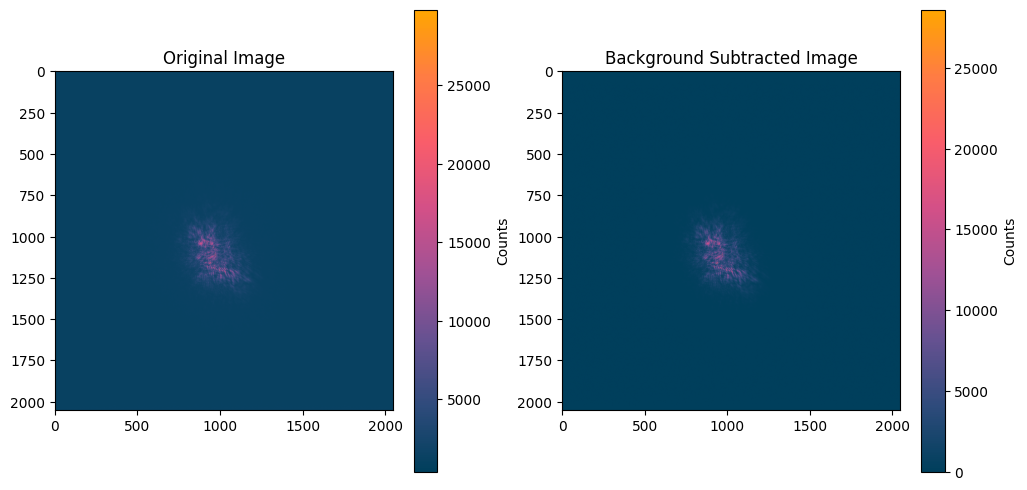

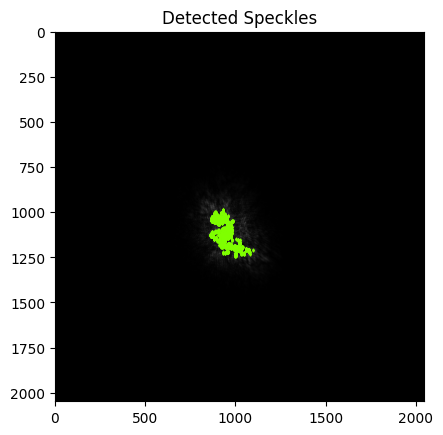

(269, 2)
Number of speckles found: 2897
Number of real speckles found: 269


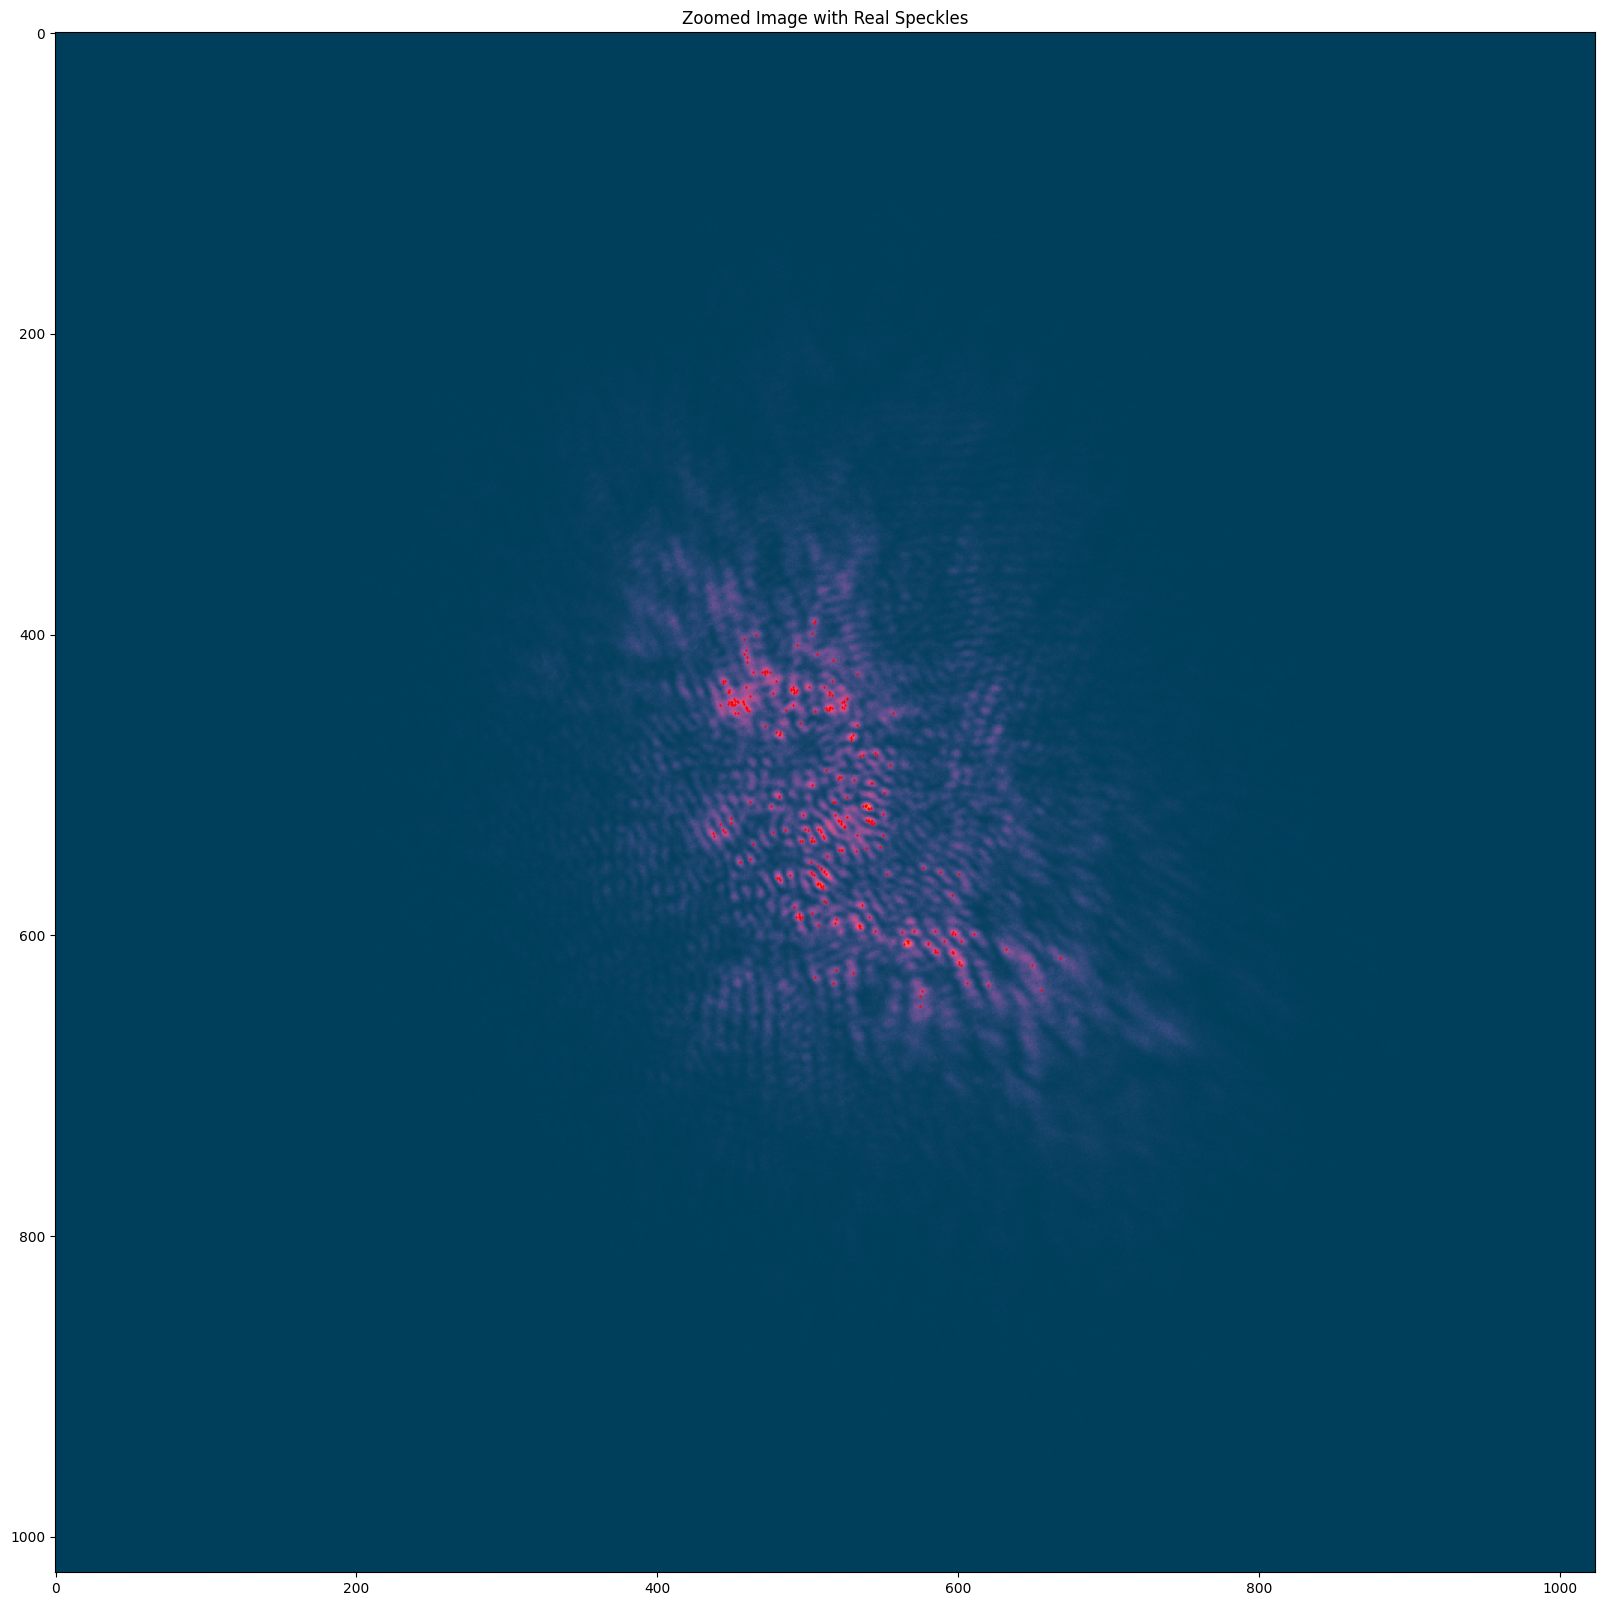

Filtered speckles: 120


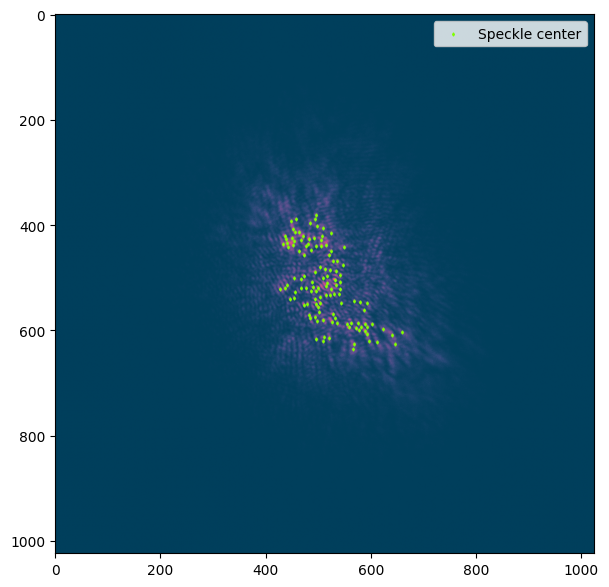

Filtered speckles after removing distant ones: 120


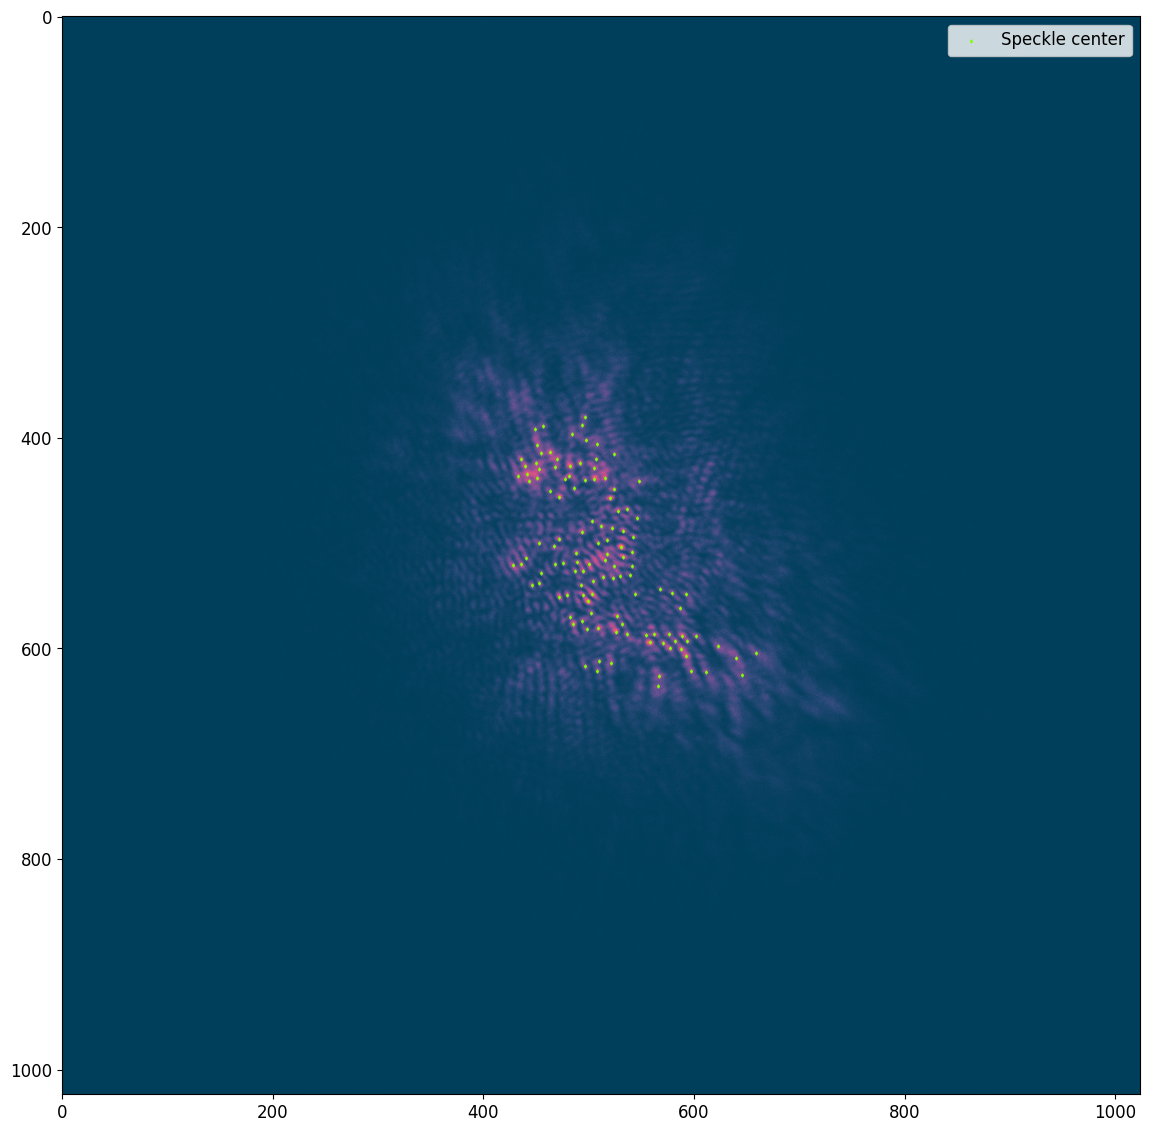

In [50]:
#del ome_data
gc.collect()
################################################################################
file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\Algol_1kHz_1_MMStack_Pos0.ome.tif")
file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\febbraio\arcturus_633nm_10ms.ome.tif")
#file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\marzo\4-03\castor_40ms_elev75.tif")
file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\marzo\4-03\aldebaran_marzo_40ms_elev30.tif")
#file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\marzo\4-03\castor_marzo_40ms_elev75.tif")
check_radius = int(diffraction_limit_arcseconds*0.5/plate_scale) # corrisponde al raggio del disco di airy in pixel
#print ("Check radius in pixels: ", check_radius)
speckle_threshold = 10000
imagenumber = 0 
ome_file = file
ome_data = tifffile.imread(ome_file)[:5000]
data_raw=ome_data[imagenumber]
###################################################################################

poisson_error = np.sqrt(data_raw)

# Estimate the background error (assuming a constant background level)
background_level = np.median(data_raw)
background_error = np.sqrt(background_level)

# Combine the signal and background errors to get the total error
total_error = np.sqrt(poisson_error**2 + background_error**2)

# Estimate the background using the total error
background_estimate = data_raw - total_error

background_estimate[background_estimate < 0] = 0

print(f"Background level: {background_level}")
print(f"Background error: {background_error}")
print(background_estimate)

plt.figure(figsize=(12, 6))

data = data_raw - background_level
data[data<0] = 0
print(data.shape)

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(data_raw, cmap=custom_cmap)
plt.title('Original Image')
plt.colorbar(label='Counts')

# Plot the background subtracted image
plt.subplot(1, 2, 2)
plt.imshow(data, cmap=custom_cmap)
plt.title('Background Subtracted Image')
plt.colorbar(label='Counts')

plt.show()




from PIL import Image

logging.getLogger().setLevel(logging.INFO)

#data = ome_data[20]
#speckle_threshold=1500 #10000#7000
# Define the radius to check for a larger count
#check_radius = 4

###############################################################################################
###########################     SOLO PER 10KHZ ################################################
#center_y, center_x = data.shape[0] // 2, data.shape[1] // 2

#search_radius = 80

#y, x = np.ogrid[:data.shape[0], :data.shape[1]]
#mask = (x - center_x)**2 + (y - center_y)**2 <= search_radius**2
################################################################################################
################################################################################################

# Apply the mask to the data to find speckles within the search radius
speckle_coords = np.column_stack(np.where((data > speckle_threshold)))# & mask))


# Show the image with the speckles highlighted 
plt.imshow(data, cmap='gray')
plt.scatter(speckle_coords[:, 1], speckle_coords[:, 0], color='chartreuse', s=2, marker='d')
plt.title('Detected Speckles')
plt.show()

# List to store the real speckles
real_speckles = []

# Iterate over each speckle found
for coord in speckle_coords:
    y, x = coord
    max_count = data[y, x]
    speckle = coord
    
    # Check the surrounding pixels within the radius
    for dy in range(-check_radius, check_radius + 1):
        for dx in range(-check_radius, check_radius + 1):
            ny, nx = y + dy, x + dx
            if 0 <= ny < data.shape[0] and 0 <= nx < data.shape[1]:
                if data[ny, nx] > max_count:
                    max_count = data[ny, nx]
                    speckle = [ny, nx]
                    
    if not any(np.array_equal(speckle, x) for x in real_speckles):
        real_speckles.append(speckle)
    
# Convert real speckles to numpy array
real_speckles = np.array(real_speckles)
print(real_speckles.shape)

# Define the zoom factor
zoom_factor = 2

# Calculate the center of the real speckles
center_x = int(real_speckles[:, 1].mean())
center_y = int(real_speckles[:, 0].mean())

# Define the zoomed area
x1 = max(center_x - data.shape[1] // (2 * zoom_factor), 0)
x2 = min(center_x + data.shape[1] // (2 * zoom_factor), data.shape[1])
y1 = max(center_y - data.shape[0] // (2 * zoom_factor), 0)
y2 = min(center_y + data.shape[0] // (2 * zoom_factor), data.shape[0])

# Crop the zoomed area from the original image
zoomed_image = data[y1:y2, x1:x2]

 
print("Number of speckles found:", len(speckle_coords))
print("Number of real speckles found:", len(real_speckles))

# Save the last plot as an image with very large resolution
fig, ax = plt.subplots(figsize=(20, 20))  # Increase the figure size for higher resolution
ax.imshow(zoomed_image, cmap=custom_cmap)
ax.scatter(real_speckles[:, 1] - x1, real_speckles[:, 0] - y1, color='red', s=0.5, marker='d')
ax.set_title('Zoomed Image with Real Speckles')
#plt.savefig('real_speckles_r=5.png', dpi=500)  # Save with high resolution
plt.show()





logging.getLogger().setLevel(logging.INFO)


filtered_speckles = []

for speckle in real_speckles:
    y, x = speckle
    max_count = data[y, x]
    keep_speckle = True
    # Check for speckles that are closer than N pixels
    for other_speckle in filtered_speckles:
        distance = np.sqrt((other_speckle[0] - y)**2 + (other_speckle[1] - x)**2)
        if distance < 5:   # change here to change the radius (in pixels)
            if data[other_speckle[0], other_speckle[1]] > max_count:
                keep_speckle = False
            else:
                filtered_speckles = [fs for fs in filtered_speckles if not np.array_equal(fs, other_speckle)]
    
    if keep_speckle:
        filtered_speckles.append([y, x])

# Convert filtered speckles to numpy array
filtered_speckles = np.array(filtered_speckles)

h, w = data.shape
        # solo speckle tali che  [y-radius:y+radius+1, x-radius:x+radius+1] stia  dentro l’immagine
ys = filtered_speckles[:, 0]
xs = filtered_speckles[:, 1]
mask = (
    (ys - radius >= 0) &
    (ys + radius + 1 <= h) &
    (xs - radius >= 0) &
    (xs + radius + 1 <= w)
    )
filtered_speckles = filtered_speckles[mask]

# Print the filtered speckles
print("Filtered speckles:", len(filtered_speckles))

# Define the zoom factor
zoom_factor = 2

# Calculate the center of the filtered speckles
center_x = int(filtered_speckles[:, 1].mean())
center_y = int(filtered_speckles[:, 0].mean())

# Define the zoomed area
x1 = max(center_x - data.shape[1] // (2 * zoom_factor), 0)
x2 = min(center_x + data.shape[1] // (2 * zoom_factor), data.shape[1])
y1 = max(center_y - data.shape[0] // (2 * zoom_factor), 0)
y2 = min(center_y + data.shape[0] // (2 * zoom_factor), data.shape[0])

# Crop the zoomed area from the original image
zoomed_image = data[y1:y2, x1:x2]

# Display the zoomed image with the filtered speckles highlighted
plt.figure(figsize=(7, 7))  # Increase the figure size for larger image
plt.imshow(zoomed_image, cmap=custom_cmap)
plt.scatter(filtered_speckles[:, 1] - x1, filtered_speckles[:, 0] - y1, color='chartreuse', s=2, marker='d', label='Speckle center')
plt.title('')
plt.legend()
plt.show()

###########################################################################################################
############################################ SOLO PER 10KHZ ##############################################
########################################################################################################
# Calculate the barycenter of the filtered speckles
#barycenter_x = filtered_speckles[:, 1].mean()
#barycenter_y = filtered_speckles[:, 0].mean()

# Define a maximum distance from the barycenter to consider a speckle as valid
#max_distance = 70  

# Calculate the distance of each speckle from the barycenter
#distances = np.sqrt((filtered_speckles[:, 1] - barycenter_x)**2 + (filtered_speckles[:, 0] - barycenter_y)**2)

###############################################################################################
###########################     SOLO PER 10KHZ ################################################
# Filter out speckles that are farther than the maximum distance from the barycenter
# filtered_speckles = filtered_speckles[distances <= max_distance]
########################################################################################################
########################################################################################################

print("Filtered speckles after removing distant ones:", len(filtered_speckles))
plt.figure(figsize=(14, 14)) 
plt.imshow(zoomed_image, cmap=custom_cmap)
plt.scatter(filtered_speckles[:, 1] - x1, filtered_speckles[:, 0] - y1, color='chartreuse', s=2, marker='d', label='Speckle center')
plt.title('', fontsize='large')
plt.legend(fontsize='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.show()

In [15]:
from astropy.io import fits

def extract_data_from_fits(file_path):
    """
    Opens a FITS file, reads all HDUs, and extracts the data and header from each.

    Parameters:
    - file_path (str): The path to the FITS file.

    Returns:
    - data_dict (dict): A dictionary where keys are HDU names (or indices if no name)
                         and values are dictionaries containing 'data' and 'header'.
                         Returns None if the file cannot be opened or read.
    """
    try:
        hdul = fits.open(file_path)
        data_dict = {}

        for i, hdu in enumerate(hdul):
            hdu_name = hdu.name if hdu.name else f"HDU_{i}"
            data_dict[hdu_name] = {
                'data': hdu.data,
                'header': dict(hdu.header)  # Convert header to a standard dictionary
            }
        hdul.close()
        return data_dict

    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        return None
    except Exception as e:
        print(f"Error: An error occurred while opening or reading the file: {e}")
        return None

# Example usage:
file_path = 'outputs/results_aldebaran_marzo_40ms_elev30.tif.fits'  # Replace with your file path
extracted_data = extract_data_from_fits(file_path)

if extracted_data:
    for hdu_name, content in extracted_data.items():
        print(f"HDU Name: {hdu_name}")
        print("Header:")
        for key, value in content['header'].items():
            print(f"  {key}: {value}")
        print("Data:")
        print(content['data'])
        print("-" * 40)
else:
    print("No data was extracted.")

HDU Name: PRIMARY
Header:
  SIMPLE: True
  BITPIX: 8
  NAXIS: 0
  EXTEND: True
Data:
None
----------------------------------------
HDU Name: FWHM_MEAN
Header:
  XTENSION: IMAGE
  BITPIX: -64
  NAXIS: 1
  NAXIS1: 2
  PCOUNT: 0
  GCOUNT: 1
  EXTNAME: FWHM_MEAN
Data:
[0.12322746 0.11668639]
----------------------------------------
HDU Name: FWHM_MEDIAN
Header:
  XTENSION: IMAGE
  BITPIX: -64
  NAXIS: 1
  NAXIS1: 2
  PCOUNT: 0
  GCOUNT: 1
  EXTNAME: FWHM_MEDIAN
Data:
[0.12466757 0.11766614]
----------------------------------------
HDU Name: FWHM_STD
Header:
  XTENSION: IMAGE
  BITPIX: -64
  NAXIS: 1
  NAXIS1: 2
  PCOUNT: 0
  GCOUNT: 1
  EXTNAME: FWHM_STD
Data:
[0.01849506 0.02176886]
----------------------------------------
HDU Name: CENTROID
Header:
  XTENSION: IMAGE
  BITPIX: -64
  NAXIS: 2
  NAXIS1: 2
  NAXIS2: 2
  PCOUNT: 0
  GCOUNT: 1
  EXTNAME: CENTROID
Data:
[[1116.83546098  954.40331828]
 [1112.70907926  949.09251947]]
----------------------------------------
HDU Name: RMS
Header:


# <span style="color:blue; font-size: 1em;"> Grafici

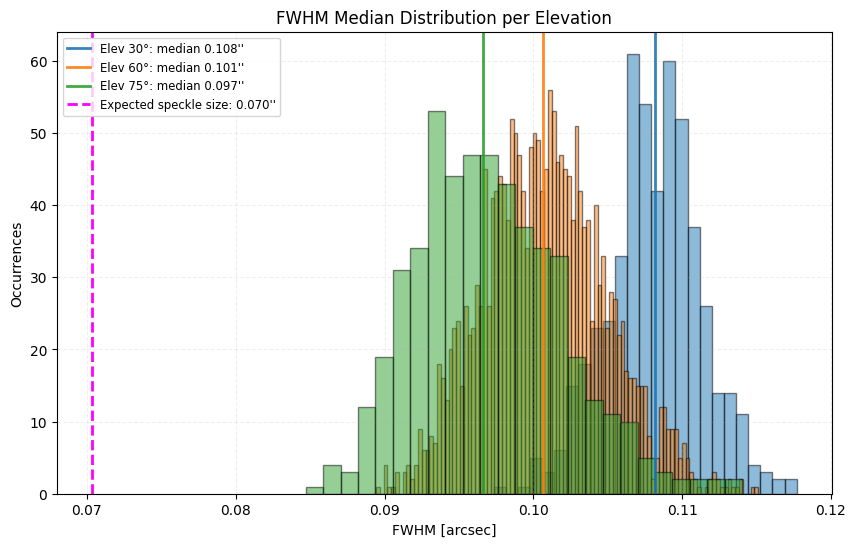

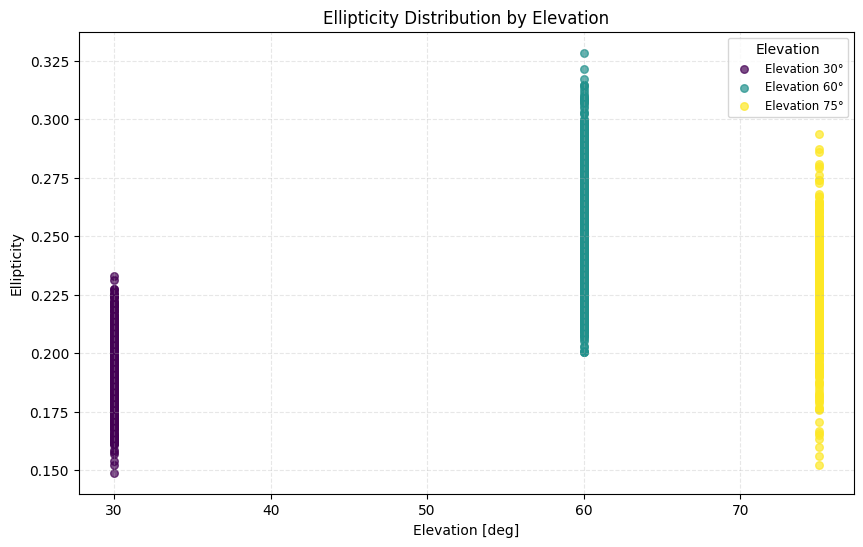

In [ ]:
import re
def extract_elevation(filename):
    match = re.search(r'elev(\d+)', filename)
    if match:
        return int(match.group(1))
    else:
        return None

def gaussiana(bins, media, sigma):
	x = np.zeros(len(bins)-1)
	for i in range(len(x)):
		x[i] = (bins[i]+bins[i+1])/2
	y = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-media)**2/(2*sigma**2))
	return x, y

    # Read the CSV file
df = pd.read_csv(output_csv_all)

    # Get unique file names
unique_files = df['FILE'].unique()

plt.figure(figsize=(10, 6))
for file_name in unique_files:
    elev = extract_elevation(file_name)
    arr = df[df['FILE'] == file_name]['FWHM_MEDIAN'].values
    num_bins = int(len(arr) / 20) if len(arr) > 0 else 10
    bin_counts, bins, _ = plt.hist(arr, bins=num_bins, alpha=0.5, edgecolor='black')
    median_val = np.median(arr)
    # Use the same color as the histogram for the median line
    color = plt.gca().patches[-1].get_facecolor()  # Get last histogram color
    plt.axvline(median_val, color=color, linestyle='-', linewidth=2, alpha=0.9,
                label=f'Elev {elev}°: median {median_val:.3f}\'\'')

plt.axvline(expected_speckle_size, color='magenta', linestyle='--', linewidth=2, label=f'Expected speckle size: {expected_speckle_size:.3f}\'\'')
plt.xlabel('FWHM [arcsec]', fontsize='medium')
plt.ylabel('Occurrences', fontsize='medium')
plt.title('FWHM Median Distribution per Elevation', fontsize='large')
plt.legend(fontsize='small')
plt.grid(True, linestyle='--', alpha=0.2)
plt.show()

# num_bins= int(len(arr) / 20)#100)
# bin_counts, bins, _ = plt.hist(arr, bins=num_bins, histtype='bar', align='mid', color='skyblue', edgecolor='black')
# plt.grid(True, linestyle='--', alpha=0.2)
# plt.xlabel('FWHM [arcsec]', fontsize='medium')
# plt.ylabel('Occurrences', fontsize='medium')
# plt.title('FWHM Median distribution at 6x', fontsize='large')
# plt.xticks(fontsize='large')
# plt.yticks(fontsize='large')
# #plt.axvline(np.mean(arr), ls='-', color='#e52704', label=f"mean value: {np.mean(arr):.3f} '' ", linewidth=0.5)
# plt.axvspan(xmin=np.mean(arr)-np.std(arr), xmax=np.mean(arr)+np.std(arr), alpha=0.5, color='#858e8e', label=f"std: {np.std(arr):.3f} ''", ls='--')
# plt.axvline(diffraction_limit_arcseconds, color='green', linestyle='-', linewidth=2, label=f"Diffraction limit: {diffraction_limit_arcseconds:.3f}''")
# plt.axvline(np.median(arr), color='purple', linestyle='-', linewidth=2, label=f"Median: {np.median(arr):.3f} ''")
# #plt.text(np.mean(arr), max(bin_counts) * 0.9, f"{np.mean(arr):.2f}", color='#e52704', ha='center')
# #plt.text(diffraction_limit_arcseconds, max(bin_counts) * 0.8, f"{diffraction_limit_arcseconds:.2f}", color='green', ha='center')
# x, y = gaussiana(bins, np.mean(arr), np.std(arr))
# #plt.xticks(list(plt.xticks()[0]) + [round(tick, 3) for tick in extraticks])
# #plt.xlim(0.15, 0.25)
# plt.plot(x, y * len(arr) * (bins[1] - bins[0]), color='red', linestyle='-') 
# #plt.legend(loc='upper left', fontsize='small')
# plt.legend(loc='best', fontsize='large')

# Extract elevation from filename using regex and compute mean ellipticity per elevation

# Function to extract elevation from filename


# Add elevation column to DataFrame
df['ELEVATION'] = df['FILE'].apply(extract_elevation)

# Group by elevation and compute mean ellipticity
ellipticity_by_elev = df.groupby('ELEVATION')['MEAN_ELLIPTICITY'].mean().reset_index()

# Scatter plot of all ellipticities, colored by elevation
elevations = df['ELEVATION'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(elevations)))

plt.figure(figsize=(10, 6))
for elev, color in zip(elevations, colors):
    mask = df['ELEVATION'] == elev
    plt.scatter(
        [elev] * mask.sum(),
        df.loc[mask, 'MEAN_ELLIPTICITY'],
        color=color,
        label=f"Elevation {elev}°",
        alpha=0.7,
        s=30
    )
plt.xlabel('Elevation [deg]')
plt.ylabel('Ellipticity')
plt.title('Speckle Ellipticity Distribution by Elevation')
plt.legend(title='Elevation', fontsize='small')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()